# Using Natural Language Processing to Classify Patents Technologies

## Business Understanding
Patents provide a wealth of information since their data has been compiled by a variety of parties in a variety of ways, both public and private. To name a few, public patent data can be accessed via websites provided by the U.S. Patent & Trademark Office (USPTO), foreign patent offices, Google Patents, etc. Data for this project has been obtained from [PatentsView.org](PatentsView.org), which is a visualization, data dissemination, and analysis platform provided by the USPTO.  

Various types of information on patents are connected at various stages in a patent's life, one being the classification of a patent's technology (e.g. mechanical, chemistry, electrical, etc.) This classification is assigned some time after a patent is filed, but it could be useful to try and predict how a patent will be classified before it is filed. In this project, I will be attempting to use machine learning to predict classifications. There are many types of classification systems ranging from broad to very specific, so for the purposes of this project, I will focus on a broader classification system.

In general, the patent-related insights and information I mention in this project come from my 10+ years of experience as a patent professional, however I also have included a list of references at the end of the readme.

## Data Understanding
To provide some background on how a patent is structured, there are 4 main parts. They are:
1. Coverpage, which provides bibliographic information such as who the inventors are, what the title is, a summary, what patents are related, etc.; 
2. Specification, which provides background information on the given invention;
3. Drawings, which serve to illustrate the invention; and
4. Claims, which detail the specific aspects of an invention that the applicant wants legally protected. 

Here is a link to patent [#10 million](https://patentimages.storage.googleapis.com/c0/d5/f7/86ad5b42759506/US10000000.pdf) if you are curious what an actual patent document looks like.

I mention these because in this project, we will use the first claim of U.S. patents to predict the classification. Claims are much shorter and more specific than the entire specification (a few lines vs. many pages) and follow a similar grammatical structure. This structure is a product of patent practitioners seeking to obtain specific and predictable legal protections, and may help in pattern recognition. Alternatively, the styles of the specifications are highly personalized to the author of the patent since the rules for the contents are not as rigid. Lastly, since each patent is required to contain at least one claim, we are guaranteed that there will not be missing data for any given patent we are analyzing. 

## Data Preparation
### Data Selection
Currently, there have been over 10 million patents granted in the U.S., so the first thing to do is reduce the amount of data being used for modeling since I am limited to what Google Collab can run in a couple hours. The parameters I used to select the data for training are:
1. Patents from the last 10 years. This provides more than 3 million patents for further trimming. PatentsView provides a page where you can access the claims for each patent issue bye year [here](https://patentsview.org/download/claims). Each file is very large, so I limited to the past 10 years to capture current technology trends while at the same time reducing the dataset. 
2. Using the World Intellectual Property Organization's (WIPO) technology fields classifications, found [here](https://patentsview.org/download/data-download-tables). Other patent classification systems are complex and hierarchical, containing hundreds of classifications. For the scale of this project, WIPO's technology fields classifications are the most approachable, having the following five categories:
    - Electrical engineering
    - Mechanical engineering
    - Instruments
    - Chemistry 
    - Other
3. Getting rid of data having more than one classification. Patents that belong to more than one technology field might confuse the model. 
4. Keeping only the first claim for each patent, which is usually the most important claim of a patent. While I could use all the claims, using a smaller amount of words/data should reduce the computing time required.

In [ ]:
# To obtain data I used, see the notebook linked below. This will download tables
# from a few different PatentsView sources and merge them into one data frame.
# ./notebooks/data_download.ipynb

### Data Cleaning

Once I selected my data, I had to clean and prepare my data for modeling. My process:
1. Merged the data obtained in steps 1 and 2 above into a single dataframe.
2. Remove claims after the 1st and remove resulting duplicate entries
3. Remove classifications of "other" since they are a catch-all rather than a technology field label
4. Limited the data to 200k of each category (which was chosen by trial and error to limit computing time). 
5. Prepared two versions of testing and training data:
  - 4-class version - this is as the data stands after previous steps
  - 2-class version - created by dropping two of the categories and keeping "Instruments" and "Mechanical engineering". 
6. Lowercase all the words so that letter case does is not taken into account
7. Stem, remove stop words, and vectorize training and test data
 - To create the list of stop words, I relied on a standard set for the English language and also added a few words that are overly common for claim language. For example, the word "method" would be used in all disciplines. The custom words come from my personal experience working with patents.
 - I chose to stem rather than lemmatize words since lemmatizing was too compuationally demanding for this dataset.
 - I chose Tfidf for the vectorizer, since it tends to work best for NLP. I filtered out the top and bottom 10% common words. From trial and error, this percentage gave a good balance of computing time with my resources but without sacrificing too much accuracy. As I progressed in this project, computing times hours and hours became a matter of issue, so it has driven several of the decisions made in this project. It is also how I selected the length of n grams.

#### Initializing this notebook.

Below are the packages needed to run this notebook. If you wish to run this yourself, you should also run the previously linked notebooks to get the data I used, or go [here](https://drive.google.com/drive/folders/12Gw7ZHghCm6pfcGJ3u-W9j2BacCOYyFS?usp=sharing) to download the dataframe and model pickles I used.

In [ ]:
#import packages
import pandas as pd
import numpy as np
import string
import re
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import pickle
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from matplotlib.pyplot import savefig, title
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.inspection import permutation_importance

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


I created a custom library to house my functions. It is loaded with the code below. 

In [ ]:
# import my custom library into colab
import sys
sys.path.append('/content/gdrive/MyDrive/Github/capstone/libraries')
import mylibrary as mylib

In [ ]:
%cd /content/gdrive/My Drive/Github/capstone

/content/gdrive/My Drive/Github/capstone


## Modeling & Evaluation
I wanted to look at how a few different sets of models and also compare how they would perform in dual or multiclass situations. 

###Models with 2-classes

I first wanted to see how traditional machine learning models would handle 2 classes. For the dual class scenario, I kept the sector "EE" (Electrical Engineering) and pooled the other categories into "non-EE". I chose to keep EE since it was the largest class in the original dataset, which makes sense since things like electronics and computing are the biggest source of innovation currently. This 2-class prediction could be useful in a scenario, for example, where EE applications needed to be prioritized over others. 

In [ ]:
# To obtain the cleaned data and see my detailed process, see the notebook 
# linked below. This will take the data downloaded in the last notebook and 
# format it for modeling. 
# ./notebooks/data_clean.ipynb

Below are the train and test data frame pickles for the dual class dataset I created.

In [ ]:
# Load train and test data
X_train = pd.read_pickle('data/X_train_2class.pkl')
X_test = pd.read_pickle('data/X_test_2class.pkl')
y_train = pd.read_pickle('data/y_train_2class.pkl')
y_test = pd.read_pickle('data/y_test_2class.pkl')

I used the above dataframes to train 3 different models:
1. Logistic Regression
2. Decision Tree
3. XG Boost

I then boosted the best-performing model, which I will explain below. 

You can load the pickled models or train the models yourself as explained below.

In [ ]:
# To train the 2-class models yourself, see the notebook linked below. 
# ./notebooks/analysis_2class.ipynb
# The below pickles load the trained models created in the above.

In [ ]:
# Load previously trained models
logreg = pickle.load(open('data/model_logreg.pkl', 'rb'))
model_dt = pickle.load(open('data/model_dt.pkl', 'rb'))
model_xgb = pickle.load(open('data/model_xgb.pkl', 'rb'))
model_gs_xgb = pickle.load(open('data/model_gs_xgb_2class.pkl', 'rb'))

#### Model 1 - Logistic Regression

I first tried logistic regression to see how it would perform. The function below takes a pretrained model (what I loaded above) and calculates the scores. The confusion matrices can be turned on or off.

In [ ]:
# Generate confusion matrix and save scores
logreg_scores = mylib.model_scores_pretrained(logreg, 'logistic_regression', 
                                        X_train, X_test, 
                                        y_train, y_test,
                                        disp_conf_matrix=False)
logreg_scores

{'train_accuracy': 0.7988983938577814, 'test_accuracy': 0.7991911686362436, 'train_recall': 0.8215867656221102, 'test_recall': 0.8219981993739107, 'train_f1': 0.8207654430196174, 'test_f1': 0.8211605503640903}


,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
logistic_regression,0.798898,0.799191,0.821587,0.821998,0.820765,0.821161


The train accuracy of 79.9% and test accuracy of 79.9% are pretty decent and indicate that were was no overfitting issue. Also, I did not tune this model since I wanted to see how other models performed on their own before deciding to do any tuning to save compuation time, which has been an ongoing consideration in this project given the size of the dataset.

####Model 2 - Decision Tree

In [ ]:
# Generate confusion matrix and save scores
dt_scores = mylib.model_scores_pretrained(model_dt, 'decision_tree',
                                        X_train, X_test, 
                                        y_train, y_test,
                                        disp_conf_matrix=False)
dt_scores

{'train_accuracy': 0.9998934527280444, 'test_accuracy': 0.7578717451023084, 'train_recall': 0.9998718800466605, 'test_recall': 0.7841726618705036, 'train_f1': 0.9999049401174404, 'test_f1': 0.784148373601822}


,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
decision_tree,0.999893,0.757872,0.999872,0.784173,0.999905,0.784148


The train acccuracy of 99.9% and test accuracy of 75.7% for this model indicates overfitting, however I wanted to see my next model before attempting tuning on this model.

#### Model 3 - XG Boost
For XG Boost, I had previously found this to be the best performing model so far, so I included the decision matrices for the train and test data as well.

{'train_accuracy': 0.8123158223277915, 'test_accuracy': 0.8122686654282498, 'train_recall': 0.8247226048026385, 'test_recall': 0.8251369054010523, 'train_f1': 0.8312344248074223, 'test_f1': 0.8313720757983041}


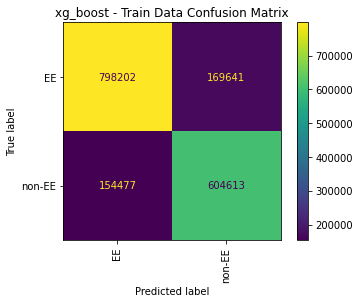

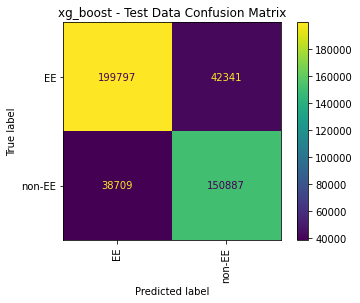

In [ ]:
# Generate confusion matrix and save scores
xgb_scores = mylib.model_scores_pretrained(model_xgb, 'xg_boost',
                                   X_train, X_test, 
                                   y_train, y_test)

From the confusion matrices, we can see that we can reliably separate the EE patents from the rest.

In [ ]:
# Calculate permutation importances
perm_importance = permutation_importance(model_xgb, X_test, y_test)

I am using permutation importance since it shuffles the data and takes an average of which features are the most influential after each shuffle, which should iron out biases in determining importances.

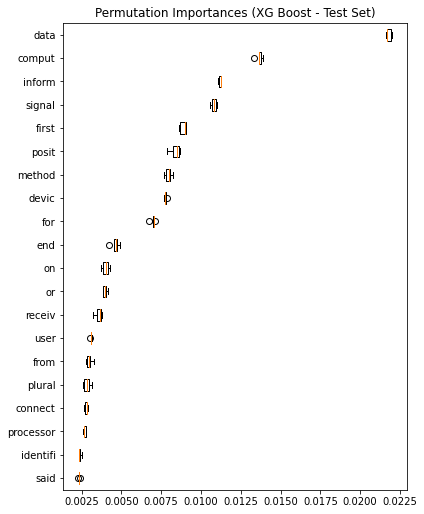

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot permutation importances
sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
n = 20
ax.boxplot(perm_importance.importances[sorted_idx][-n:].T,
           vert=False, labels=X_test.columns[sorted_idx][-n:])
ax.set_title("Permutation Importances (XG Boost - Test Set)")
fig.tight_layout()
fig.set_size_inches(6, 8)
plt.show()
savefig(f'images/perm_importance_xgb_2class.png', bbox_inches='tight', dpi=300)

From these importances, we can see the top 5 words are:

- data
- comput (stem of computer, computing, computation, etc.)
- inform
- signal
- first (stem of device, devices, etc.)

In [ ]:
# Compare the accuracy scores from the 3 previous models
scores = pd.concat([logreg_scores, dt_scores, xgb_scores])
scores

,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
logistic_regression,0.798898,0.799191,0.821587,0.821998,0.820765,0.821161
decision_tree,0.999893,0.757872,0.999872,0.784173,0.999905,0.784148
xg_boost,0.812316,0.812269,0.824723,0.825137,0.831234,0.831372


Comparing the scores, the XG Boost model is the most promising, so running a gridsearch to optimize parameters, we get the following.

{'train_accuracy': 0.8376839170946412, 'test_accuracy': 0.8321721245025873, 'train_recall': 0.8508921384976695, 'test_recall': 0.8463727296004757, 'train_f1': 0.8545639158874091, 'test_f1': 0.8497786807923953}


,train_accuracy,test_accuracy,train_recall,test_recall,train_f1,test_f1
gridsearch_xg_boost,0.837684,0.832172,0.850892,0.846373,0.854564,0.849779


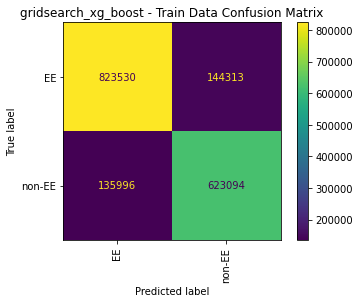

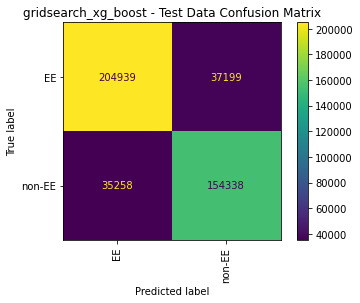

In [ ]:
xgb_gs_scores = mylib.model_scores_pretrained(model_gs_xgb, 'gridsearch_xg_boost',
                                   X_train, X_test, 
                                   y_train, y_test)
xgb_gs_scores

From the confusion matrices, we can see that we can reliably separate the EE patents from the rest

## Model with Multiclass
Next I wanted to see how the same models from the 2-class models would perform using all the classes. 

In [ ]:
# Load train and test pickles
X_train = pd.read_pickle('data/X_train_4class.pkl')
X_test = pd.read_pickle('data/X_test_4class.pkl')
y_train = pd.read_pickle('data/y_train_4class.pkl')
y_test = pd.read_pickle('data/y_test_4class.pkl')

In [ ]:
# Load previously trained models.
model_lr = pickle.load(open('data/model_logreg_4class.pkl', 'rb'))
model_dt = pickle.load(open('data/model_dt_4class.pkl', 'rb'))
model_xgb = pickle.load(open('data/model_xgb_4class.pkl', 'rb'))
model_gs_xgb = pickle.load(open('data/model_xgb_gs_4class.pkl', 'rb'))

#### Model 1 - Logistic Regression

I first tried logistic regression to see how it would perform. The function below takes a pretrained model (what I loaded above) and calculates the scores. The confusion matrices can be turned on or off. 

In [ ]:
# Evaluate model
logreg_scores2 = mylib.model_scores_pretrained(model_lr, 'logistic_regression',
                                               X_train, X_test, 
                                               y_train, y_test,
                                               disp_conf_matrix=False)

{'train_accuracy': 0.70598125, 'test_accuracy': 0.70691875}


The train accuracy of 70.6% and test accuracy of 70.7% are pretty decent and indicate that were was no overfitting issue. Also, I did not tune this model since I wanted to see how other models performed on their own before deciding to do any tuning to save compuation time, which has been an ongoing consideration in this project given the size of the dataset. 

#### Model 2 - Decision Tree
I used the same function as above, this time swapping in the decision tree model.

In [ ]:
# Evaluate next model
dt_scores2 = mylib.model_scores_pretrained(model_dt, 'decision_tree',
                                           X_train, X_test, 
                                           y_train, y_test,
                                           disp_conf_matrix=False)

{'train_accuracy': 0.9999234375, 'test_accuracy': 0.64426875}


The train acccuracy of 99.9% and test accuracy of 64.4% for this model indicates overfitting, however I wanted to see my next model before attempting tuning on this model.

#### Model 3 - XG Boost
For XG Boost, I had previously found this to be the best performing model so far, so I included the decision matrices for the train and test data as well.

{'train_accuracy': 0.720825, 'test_accuracy': 0.72039375}


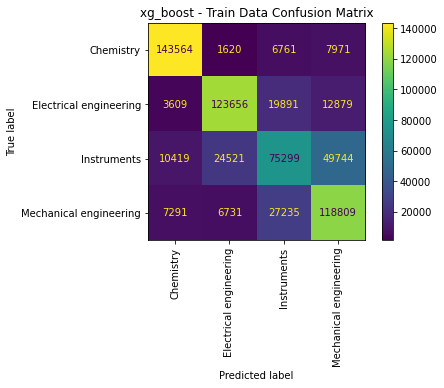

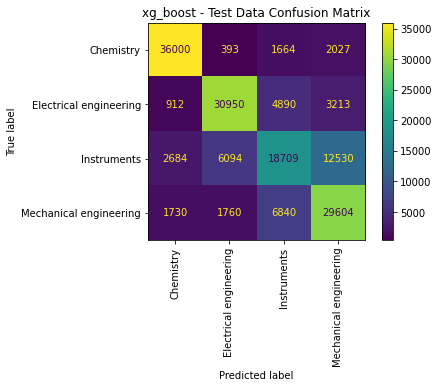

In [ ]:
xgb_scores2 = mylib.model_scores_pretrained(model_xgb, 'xg_boost',
                                   X_train, X_test, 
                                   y_train, y_test)

The confusion matrix provides some interesting insights. While the train accuracy of 72.1% and test accuracy of 72.0% are an improvement over the previous models, we can see what may be pulling that score down. This model performs best on identifying chemistry (87.1% accuracy) and electrical (78.9% accuracy) patents but struggles more with mechanical (62.4% accuracy) and instrument patents (58.3% accuracy). (I calculated the individual accuracies manually from the test confusion matrix.) I suspect that perhaps instrument topics share vocabulary with the mechanical patents, which I will investigate by looking at the most influential features.

In [ ]:
# Calculate permutation importances
perm_importance = permutation_importance(model_xgb, X_test, y_test)

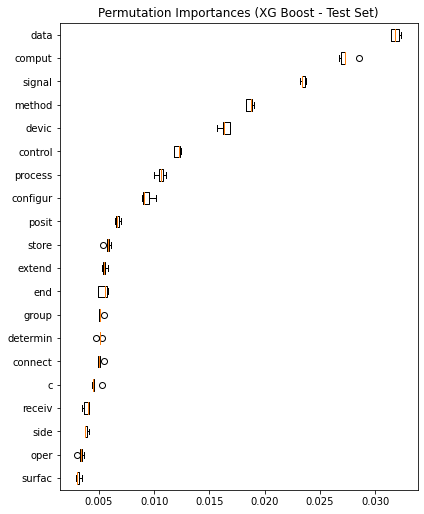

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot permutation importances
sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
n = 20
ax.boxplot(perm_importance.importances[sorted_idx][-n:].T,
           vert=False, labels=X_test.columns[sorted_idx][-n:])
ax.set_title("Permutation Importances (XG Boost - Test Set)")
fig.tight_layout()
fig.set_size_inches(6, 8)
plt.show()
savefig(f'images/perm_importance_xgb_4class.png', bbox_inches='tight', dpi=300)

From these importances, we can see the top 5 words are:
1. data
2. comput (stem of computer, computing, computation, etc.)
3. signal
4. method
5. devic (stem of device, devices, etc.)

This is in line with my initial suspicion regarding the poor performance of the "instruments" class. These words are all typical of instrumentation but could also apply to the other disciplines. It would suggest that context is important for determining classification and would be a good candidate for a deep learning model (more on that later). 

Carrying on, I will tune the best model we have so far, which is the XG Boost. 

In [ ]:
# Below is a summary of the scores for all of the models so far
scores = pd.concat([logreg_scores2, dt_scores2, xgb_scores2])
scores

,train_accuracy,test_accuracy
logistic_regression,0.705981,0.706919
decision_tree,0.999923,0.644269
xg_boost,0.720825,0.720394


#### Grid search - XG Boost
XG Boost was already performing pretty well on its own, but I wanted to run a grid search to pick the best booster and the best delta step. I was prohibited from running a more rigorous grid search because of the computing power limitations. 



{'train_accuracy': 0.7707953125, 'test_accuracy': 0.7492625}


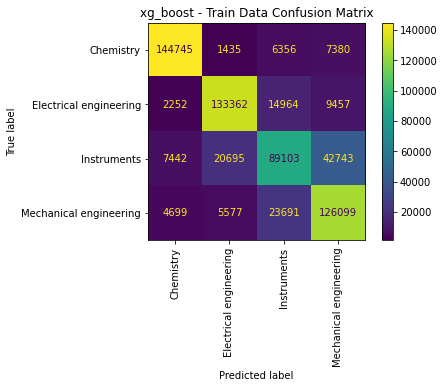

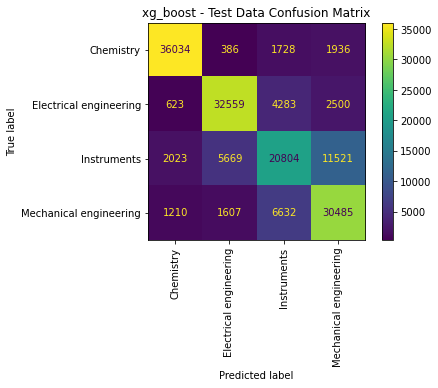

In [ ]:
xgb_gs_scores2 = mylib.model_scores_pretrained(model_gs_xgb, 'xg_boost',
                                        X_train, X_test, 
                                        y_train, y_test)

In [ ]:
xgb_gs_scores2

,train_accuracy,test_accuracy
xg_boost,0.770795,0.749263


There is a slight accuracy improvement, but still the general issue of the instrucments class more easily being confused with the others.

## Final Model

My final model was trained using the entire dataset and pickled in notebooks mentioned before. I decided to use the multi-class model since it was performing relatively well.

In [ ]:
# Load previously trained models.
final_model_4class = pickle.load(open('data/final_model.pkl', 'rb'))

The final model final with holdout data consisting of all the patents issued in 2010 that none of the other models have ever seen. It was produced via notebooks mentioned before.

In [ ]:
X = pd.read_pickle('./data/X_holdout.pkl')
y = pd.read_pickle('./data/y_holdout.pkl')

In [ ]:
y_pred = final_model_4class.predict(X)

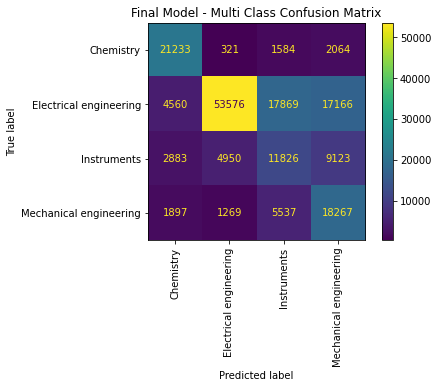

In [ ]:
final_score_4class = accuracy_score(y, y_pred)

# Plot confusion matrix for entire data
plot_confusion_matrix(final_model_4class, X=X, y_true=y,
                      values_format = 'd', xticks_rotation='vertical')
title(f'Final Model - Multi Class Confusion Matrix')
savefig(f'images/cm_Final_Model_4class.png', bbox_inches='tight', dpi=300)

In [ ]:
final_score_4class

0.6024522613065326

The accuracy of the final model with the holdout data turned out to dip to 60.2%. To me, this indicates that since the holdout patent data predates the patents used in training the final model, there could be shifts in the terms or popular technologies being addressed in these patents. 

## Conclusion

### Results
Based on the performance metrics for both the 2-class and 4-class models, the XG Boost model performed the best for both. As for what determined a classification, it appears to be a mix of keywords but also stylistic choices that practioners of each technology area lean towards.

### Recommendations
My goal for this project was to provide a proof of concept rather a model ready for distribution, since such a model would need to able to handle the hundreds of classifications. Based on the previous results, I feel proof of concept is shown that machine learning can be used to help automate the classification process for patents and could be useful to patent Offices or third parties, if they are not utilizing it in some fashion already. 

### Future Work
Deep learning is often a good fit for natural language processing, so for my next step, I would like to finalize a deep learning model. 
My preliminary but unpublished deep learning model shows extremely promising results and suggests that it could be a viable model for more complex classification systems. 

References (in progress): 
- Permutation Importance: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
- TFIDF Vectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
